In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import norm
import time
import xarray as xr

# import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("poster") #[poster, paper, talk, notebook]

import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] #added from snow class

from mpl_toolkits.axes_grid1 import make_axes_locatable

<xarray.Dataset>
Dimensions:  (time: 51, x: 1000, y: 1000)
Coordinates:
  * x        (x) float32 279207.0 279210.0 279213.0 ... 282201.0 282204.0
  * y        (y) float32 4221327.0 4221324.0 4221321.0 ... 4218333.0 4218330.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 1000, 600), meta=np.ndarray>


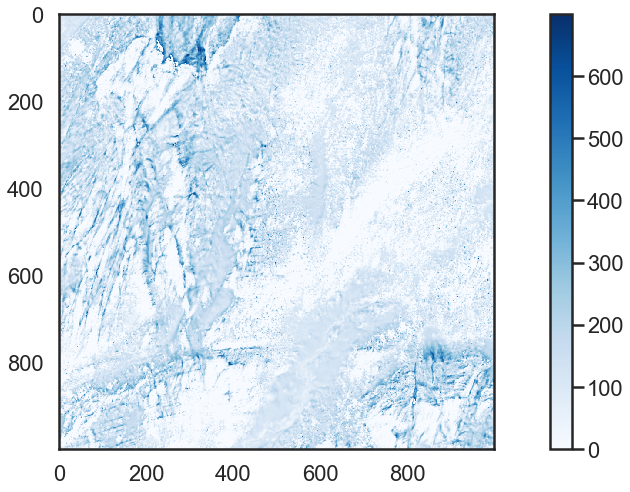

In [93]:
# fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc' #ARS
fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU
# fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
#~~~~ ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close()
# #~~~~ ds peak
# dpeak = ds.isel(time=[0,7,18,30,42,49]) 
# dpeak.close()
# ds = dpeak
# ds.close()
#~~~convert to cm
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'
#grab 2015, 2016, 2017 nearest peak SWE
# ds=ds.isel(time=slice(2,5))
# ds.close()
#northern slice of data
d = ds.isel(x=slice(8400,9400), y=slice(3000,4000))
d.close()
#~~~convert to ints again
d=d.astype(np.int16, copy=False)
print(d)
plt.figure(figsize=(20,8))
plt.imshow(d.snow.isel(time=1),cmap='Blues')
plt.colorbar()

# d.to_netcdf('~/Documents/research/sierra/data/compiled_SUPERsnow_3km_subregion.nc')
#dataset is d here! 3km by 3km area in northern Tuolumne (2 valleys west of slide canyon)

### attempt to fully use Xarray.....(right track, needs dimention work)

In [ ]:
d

In [84]:
# compute stats from xarray dataset
x_gt0 = d.snow.where(d.snow>0) #snow depths greater than zero
mu_gt0 = x_gt0.mean(dim=('x', 'y'))
sig_gt0 = x_gt0.std(dim=('x', 'y'))

mu=mu_gt0 #51 means over x,y dimention
sigma=sig_gt0 #51 stds over x,y dimention

Text(0.5, 1.0, '2013-04-29')

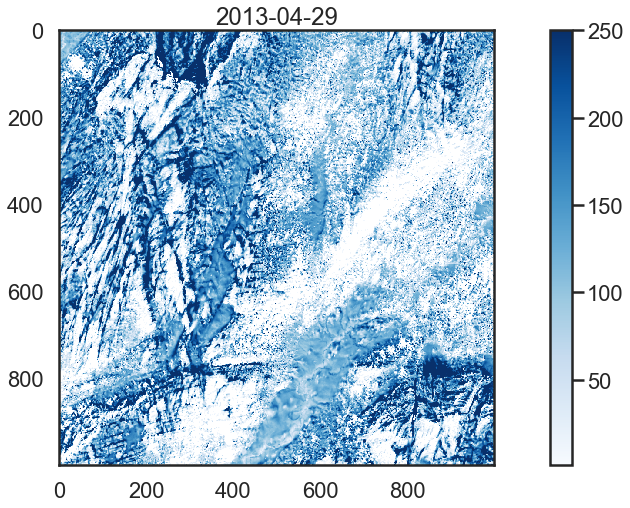

In [96]:
#plot to show you have values >0
which_date=1
plt.figure(figsize=(20,8))
plt.imshow(x_gt0.isel(time=which_date), cmap='Blues', vmax=250)
plt.colorbar()
title=(d['time'].dt.strftime('%Y-%m-%d')[which_date])
plt.title(str(title.values))

In [ ]:
#1) set number of bins to use
n_bins=100

#2) compute histogram and bin edges for each lidar layer (dim=time)
    ######~~NOTE - likely need to compute using a dimention, i.e. result should be multiple hist,bin returns
hist, bins = np.histogram(x_gt0.values[~np.isnan(x_gt0.values)], bins=n_bins, density=True)

#3) compute y
#~~NOTE - only working because it grabs one value from mu and sigma instead of working through a dim
y = norm.pdf(bins, mu.values[0], sigma.values[0]).cumsum()
#get rid of last value of y (bins and y are same size)
y /= y[-1]

#4) plot it 
plt.plot(bins, y, linestyle='--', linewidth=3)

In [ ]:
print('hist is length:', len(hist), 'type:', type(hist))
print('bins is length:', len(bins), 'type:', type(bins))
print('mu is length:', len(mu), 'type:', type(mu))
print('sigma is length:', len(sigma), 'type:', type(sigma))

### try with Will
problem: hist and bins computes over full dataset
y uses bins, mu, and sigma to compute. 
    bins - all data being used
    mu and sigma - one values per lidar flight

In [ ]:
#1) set number of bins to use
n_bins=100

#2) compute histogram and bin edges for each lidar layer (dim=time)
#~~NOTE - likely need to compute using a dimention, i.e. result should be multiple hist,bin returns
hist, bins = np.histogram(x_gt0.values[~np.isnan(x_gt0.values)], bins=n_bins, density=True)

#3) compute y
#~~NOTE - only working because it grabs one value from mu and sigma instead of working through a dim
# y = norm.pdf(bins, mu.values[0], sigma.values[0]).cumsum()
y = norm.pdf(bins, mu, sigma).cumsum()
#get rid of last value of y (bins and y are same size)
y /= y[-1]

#4) plot it 
plt.plot(bins, y, linestyle='--', linewidth=3)

In [ ]:
x_gt0.values

### numpy rescue (using code from 50m cdf)

In [3]:
def compute_cdf(depth_array, n_bins):
    
    '''
    Compute Cumulative Density Function (CDF). Solves the cumulative probability of a given x value.
    Determines the probability that a random observation will be less/greater than a certain value.
    
    What is the probability (read y-axis) that you get a snow depth measurement in the Tuolumne Basin
    that is ____ meters deep (x_axis)? 
    
    at the 1, you say: 100% of the time you get a measurement that is (x-axis) meters or less
    at the .5 you say: 50% of the time you get a measurment that is (x-axis) meters or less
    
        args:
            depth_array: ndarray of snow depth values
            n_bins: number of bins
          
            
        returns:
            bins: bin edges (left edges and final right side edge)
            y: cumulative sum of probability density function (PDF). 
            
    '''
    
    d = depth_array[depth_array > 0] #data are inside masked area and >0, scalar
    
    mu = np.nanmean(d)
    sigma = np.nanstd(d)
    
    hist, bins = np.histogram(d, bins=n_bins, density=True)
    
    y = norm.pdf(bins, mu, sigma).cumsum()
    y /= y[-1]
    
    return bins, y

In [ ]:
# #CLOSE!!!!!

# # ~~~ Annual CDF plots
# fs_titles = 34
# fs_labels = 30
# fs_axes = 30
# fs_text = 26
# fs_legend = 30

# n_bins=100 #number of bins in histogram
# years = list(range(2013,2019)) #which years
# date_df = d.time.to_dataframe() #store dates in dataframe

# fig,axs=plt.subplots(2,3,figsize = (30, 20)) #make one figure, with axs (plot1, plot2, etc.)
# flat_ax = axs.flat #flatten the axes (subplots)

# for ii, year in enumerate(years):
#     print('~~~YEAR~~~', year)
#     ax = flat_ax[ii] #which plot are you plotting
    

#     startTime = pd.to_datetime("10-01-{}".format(year-1))
#     endTime = pd.to_datetime("09-30-{}".format(year))

#     current_df = date_df.loc[startTime:endTime] #buy pickles!

#     for i,row in current_df.iterrows():
#         f = row['time']
#         print(f)        
#         for layer in d.snow.values:

#             bins,y = compute_cdf(layer, n_bins) #layer is ndarray

#             ax.plot(bins, y,  linestyle='-', linewidth=2, label=str(i.date())) #color=cycle[i],
#             ax.set_xlim(0,750)
#         ax.set_title('{}'.format(year), fontsize = fs_titles-3)
#         ax.set_xlabel('Snow Depth (cm)', fontsize = fs_axes-2)
#         ax.set_ylabel('Probability', fontsize = fs_axes-2)
#         ax.legend()

# # plt.tight_layout()
# # # plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/3m_depth/annual_cdf_subplots.png', dpi=150)
# # plt.show()

~~~YEAR~~~ 2013
~~~YEAR~~~ 2014
~~~YEAR~~~ 2015
~~~YEAR~~~ 2016
~~~YEAR~~~ 2017
~~~YEAR~~~ 2018


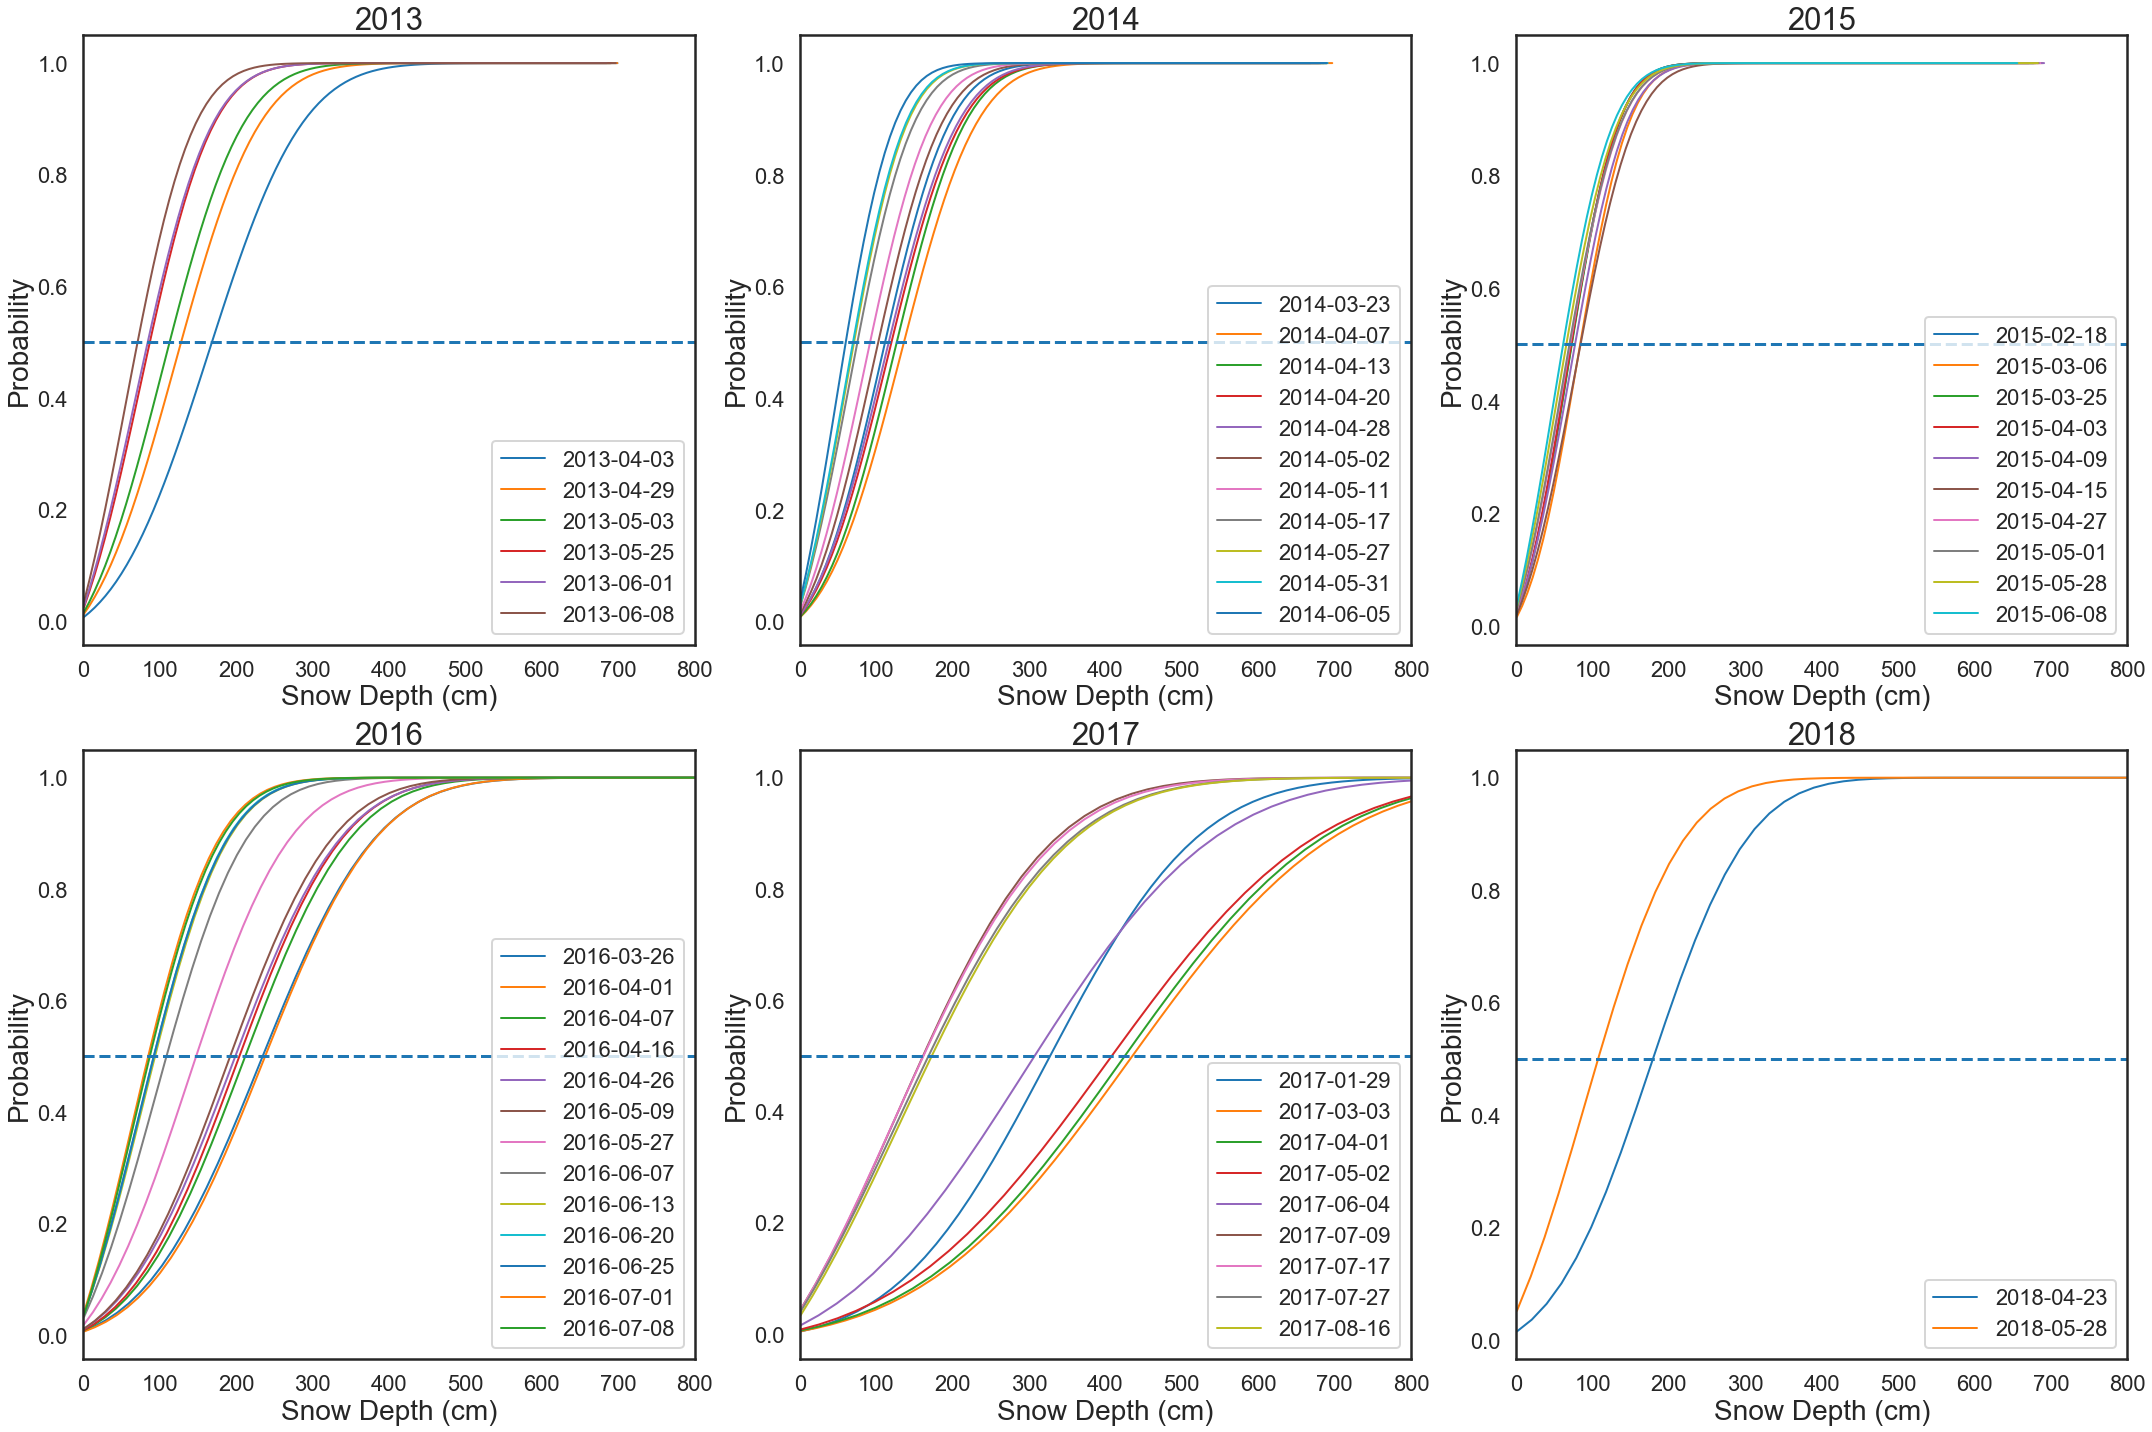

In [82]:
# ~~~ Annual CDF plots
fs_titles = 34
fs_labels = 30
fs_axes = 30
fs_text = 26
fs_legend = 30

n_bins=100 #number of bins in histogram
years = list(range(2013,2019)) #which years
# date_df = d.time.to_dataframe() #store dates in dataframe

fig,axs=plt.subplots(2,3,figsize = (30, 20)) #make one figure, with axs (plot1, plot2, etc.)
flat_ax = axs.flat #flatten the axes (subplots)

for ii, year in enumerate(years):
    print('~~~YEAR~~~', year)
    ax = flat_ax[ii] #which plot are you plotting
    
    startTime = pd.to_datetime("10-01-{}".format(year-1))
    endTime = pd.to_datetime("09-30-{}".format(year))

    d_sub=d.sel(time=slice(startTime,endTime))

    for array_index, time in enumerate(d_sub['time'].dt.strftime('%Y-%m-%d').values):
    #for layer in d_sub.snow.values:

        # array_index is a number between 0 and the length of the times in the 'cube'
        # time is the string that corresponds to array_index, grabbed from the xarray dataframe 

        layer = d_sub.snow.values[array_index,:,:] # this grabs the 'array_index' number of the 'cube' with everything in the x,y direction

        bins,y = compute_cdf(layer, n_bins) #layer is ndarray
        ax.plot(bins, y, linestyle='-', linewidth=2, label=time) #color=cycle[i],
        ax.set_xlim(0,800)
    ax.axhline(y=0.5, linestyle='--',linewidth='3')
    ax.set_title('{}'.format(year), fontsize = fs_titles-3)
    ax.set_xlabel('Snow Depth (cm)', fontsize = fs_axes-2)
    ax.set_ylabel('Probability', fontsize = fs_axes-2)
    ax.legend()

plt.tight_layout()
# # plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/3m_depth/annual_cdf_subplots.png', dpi=150)
# plt.show()

#### extra stuff...ie good code

In [ ]:
for grp in d.groupby('time.year').groups:
    print(grp)

In [ ]:
d.groupby('time.year').groups